# Выбор локации для скважины

<div style="border:solid Chocolate 2px; padding: 40px">

## Описание проекта

Нам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Необходимо построить модель для определения региона, где добыча принесёт наибольшую прибыль. 

<b>Описание данных</b>
    
Данные находятся в файле csv.

* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей)

## Загрузка и подготовка данных

Загрузим и проверим данные.

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np
from numpy.random import RandomState
from scipy import stats as st
import matplotlib.pyplot as plt

C:\Users\Katya\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
path = '/datasets/'

In [3]:
try:
    data_0 = pd.read_csv('geo_data_0.csv')
    data_1 = pd.read_csv('geo_data_1.csv')
    data_2 = pd.read_csv('geo_data_2.csv')
except:
    data_0 = pd.read_csv(path + 'geo_data_0.csv')
    data_1 = pd.read_csv(path + 'geo_data_1.csv')
    data_2 = pd.read_csv(path + 'geo_data_2.csv')    

In [4]:
def describe_data(df, num):
    display(df.head())
    df.info()
    df['product'].hist(bins= int(max(df['product']) - min(df['product']) + 1),
                       figsize=(10, 5))
    plt.grid(True)
    plt.title(f'Гистограмма объёмов запасов в скважине (тыс. баррелей) в регионе {num}\n', fontsize=16)
    plt.xlabel('Объёмы запасов в скважине (тыс. баррелей)', fontsize=12)
    plt.ylabel('Количество значений', fontsize=12)
    plt.show()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


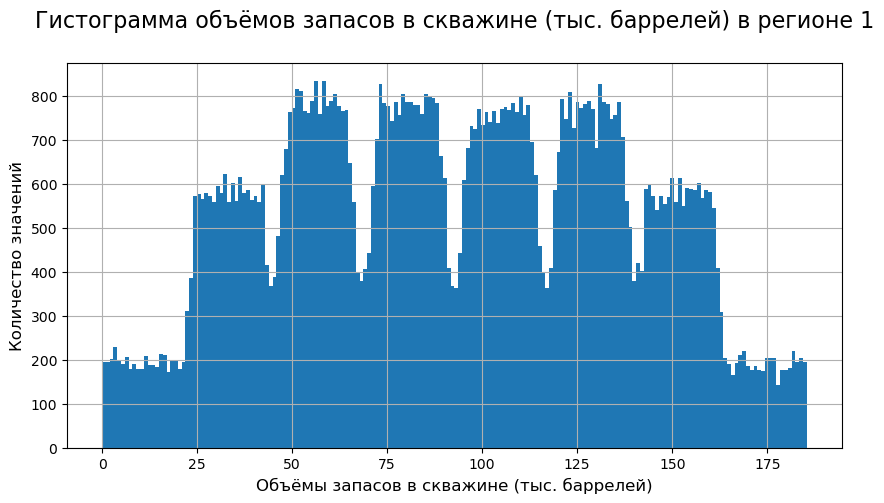

In [5]:
describe_data(data_0, 1)

Пропусков в данных нет. Типы данных верные. Проверим на дубликаты.

In [6]:
data_0['id'].value_counts().sort_values(ascending=False).head(15)

id
fiKDv    2
AGS9W    2
Tdehs    2
74z30    2
A5aEY    2
bsk9y    2
TtcGQ    2
HZww2    2
bxg6G    2
QcMuo    2
j9Oui    1
zIYPq    1
1YYm1    1
b8WQ6    1
OLuZU    1
Name: count, dtype: int64

In [7]:
id_list = data_0['id'].value_counts().sort_values(ascending=False).to_frame().query('count>1').index.to_list()
data_0[data_0['id'].isin(id_list)]

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205


В данных есть повторяющиеся id. Так как из имеющихся данных мы не можем определить по какой причине появились эти дубликаты, и их немного, можем просто удалить их. Поступим также и с остальными датасетами.

Напишем функцию для очистки датасетов.

In [8]:
def clean_dataset(df):
    print('Дублирующиеся id:', 
          df['id'].value_counts().sort_values(ascending=False).to_frame().query('count>1').index.to_list())
    print('Количество строк до очистки:', df.shape[0])
    id_list = df['id'].value_counts().sort_values(ascending=False).to_frame().query('count>1').index.to_list()
    df = df[~(df['id'].isin(id_list))]
    print('Количество строк после очистки:', df.shape[0])
    return df

In [9]:
data_0 = clean_dataset(data_0)

Дублирующиеся id: ['fiKDv', 'AGS9W', 'Tdehs', '74z30', 'A5aEY', 'bsk9y', 'TtcGQ', 'HZww2', 'bxg6G', 'QcMuo']
Количество строк до очистки: 100000
Количество строк после очистки: 99980


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


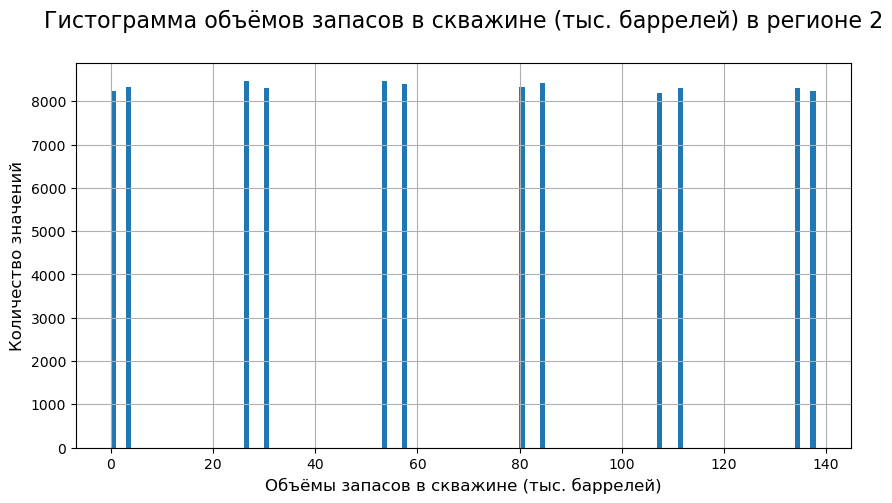

In [10]:
describe_data(data_1, 2)

In [11]:
data_1 = clean_dataset(data_1)

Дублирующиеся id: ['wt4Uk', 'bfPNe', 'LHZR0', '5ltQ6']
Количество строк до очистки: 100000
Количество строк после очистки: 99992


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


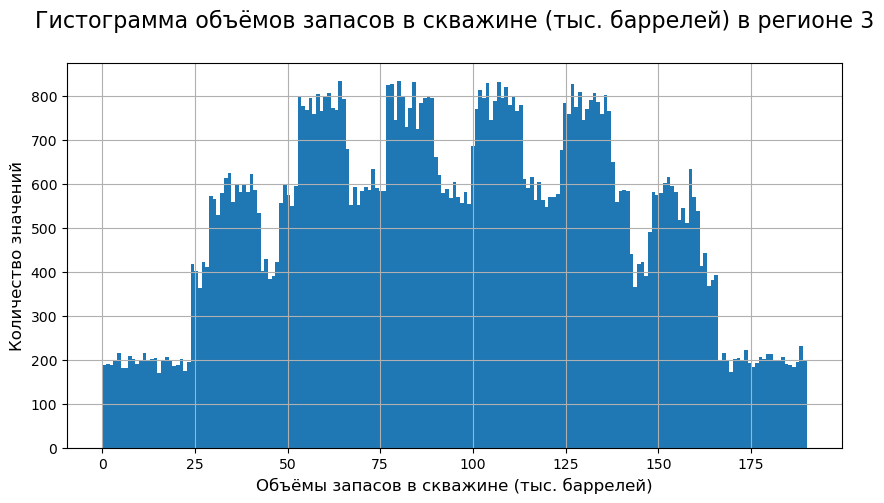

In [12]:
describe_data(data_2, 3)

In [13]:
data_2 = clean_dataset(data_2)

Дублирующиеся id: ['VF7Jo', 'Vcm5J', 'KUPhW', 'xCHr8']
Количество строк до очистки: 100000
Количество строк после очистки: 99992


**Вывод**

Мы проверили данные по трём регионам. Пропусков в данных не было, типы данных были верные. Мы удалили строки с дубликатами в id. Распределение признака `product` похоже на нормальное.

## Обучение и проверка модели

Напишем функцию, которая раделяет данные на обучающие и валидационные.

In [14]:
def split(df):
    df = df.drop(['id'], axis=1)
    target = df['product']
    features = df.drop(['product'], axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25,
                                                                             random_state=12345)
    print('Размер обучающей выборки:', features_train.shape[0], 'строк')
    print('Размер валидационной выборки:', features_valid.shape[0], 'строк')
    return features_train, features_valid, target_train, target_valid

Напишем функцию, которая создаст и обучит модель для каждого региона, а также выведет на экран необходимые нам занчения и метрики, а именно: средний запас предсказанного сырья, RMSE модели, RMSE случайной модели.

In [15]:
def create_model(features_train, features_valid, target_train, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    print('Средний запас предсказанного сырья:', predictions_valid.mean())
    
    RMSE = mean_squared_error(target_valid, predictions_valid)**0.5

    predictions_mean = pd.Series(target_valid_0.mean(), index=target_valid.index)
    RMSE_mean = mean_squared_error(target_valid, predictions_mean)**0.5

    print('Квадратный корень из средней квадратичной ошибки RMSE:', RMSE)
    print('Квадратный корень из средней квадратичной ошибки RMSE случайной модели:', RMSE_mean)
    
    return model, predictions_valid, RMSE, RMSE_mean

### Модель для региона 1

Применим ранее написанные функции к первому датасету. Обучим модель для первого региона. Посмотрим средний запас предсказанного сырья. Посмотрим RMSE модели. Сравним её с RMSE случайной модели.

In [16]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = split(data_0)

Размер обучающей выборки: 74985 строк
Размер валидационной выборки: 24995 строк


In [17]:
model_0, predictions_valid_0, RMSE_0, RMSE_0_mean = create_model(
    features_train_0, features_valid_0, target_train_0, target_valid_0)

Средний запас предсказанного сырья: 92.42384109947359
Квадратный корень из средней квадратичной ошибки RMSE: 37.716904960382735
Квадратный корень из средней квадратичной ошибки RMSE случайной модели: 44.34705265024233


RMSE модели меньше чем RMSE случайной модели. То есть модель предсказывает целевой признак достаточно хорошо.

### Модель для региона 2

Обучим модель для второго региона. Посмотрим средний запас предсказанного сырья, RMSE модели. Сравним её с RMSE случайной модели.

In [18]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = split(data_1)

Размер обучающей выборки: 74994 строк
Размер валидационной выборки: 24998 строк


In [19]:
model_1, predictions_valid_1, RMSE_1, RMSE_1_mean = create_model(
    features_train_1, features_valid_1, target_train_1, target_valid_1)

Средний запас предсказанного сырья: 68.98311857983123
Квадратный корень из средней квадратичной ошибки RMSE: 0.8914901390348527
Квадратный корень из средней квадратичной ошибки RMSE случайной модели: 51.58851580890595


RMSE модели существенно меньше чем RMSE случайной модели. То есть модель предсказывает целевой признак достаточно хорошо.

### Модель для региона 3

Обучим модель для второго региона. Посмотрим средний запас предсказанного сырья, RMSE модели. Сравним её с RMSE случайной модели.

In [20]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = split(data_2)

Размер обучающей выборки: 74994 строк
Размер валидационной выборки: 24998 строк


In [21]:
model_2, predictions_valid_2, RMSE_2, RMSE_2_mean = create_model(
    features_train_2, features_valid_2, target_train_2, target_valid_2)

Средний запас предсказанного сырья: 95.11622302076479
Квадратный корень из средней квадратичной ошибки RMSE: 39.975543264382345
Квадратный корень из средней квадратичной ошибки RMSE случайной модели: 44.62320561829149


RMSE модели меньше чем RMSE случайной модели. То есть модель предсказывает целевой признак достаточно хорошо.

Создадим общий датасет для более удобного сравнения регионов.

In [22]:
dt = pd.DataFrame(data={'Регион': [1, 2, 3], 'Средний запас сырья': [predictions_valid_0.mean(), predictions_valid_1.mean(), predictions_valid_2.mean()], 'RMSE': [RMSE_0, RMSE_1, RMSE_2], 'RMSE случайной модели': [RMSE_0_mean, RMSE_1_mean, RMSE_2_mean]})
dt

,Регион,Средний запас сырья,RMSE,RMSE случайной модели
0,1,92.423841,37.716905,44.347053
1,2,68.983119,0.891490,51.588516
2,3,95.116223,39.975543,44.623206


**Вывод**

Мы обучили три модели логистической регрессии для трёх разных регионов. По среднему запасу сырья лидирует третий регион. Однако лучший покатель RMSE модели во втором регионе.

## Подготовка к расчёту прибыли

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.

In [23]:
# Цена за 1000 баррелей
PRICE_PER_1000_BARREL = 450000

# Бюджет на разработку скважин в регионе
DEVELOPMENT_BUDGET = 10e9

# Количество скважин для разработки
NUMBER_OF_WELLS = 200

# Достаточный объём сырья для безубыточной разработки новой скважины
minimal_product_amount_per_well = DEVELOPMENT_BUDGET / NUMBER_OF_WELLS / PRICE_PER_1000_BARREL
print('Достаточный объём сырья для безубыточной разработки новой скважины', round(minimal_product_amount_per_well), 'тыс. баррелей')

Достаточный объём сырья для безубыточной разработки новой скважины 111 тыс. баррелей


**Вывод**

Хорошо видно, что в среднем запасов сырья в каждом регионе недостаточно для безубыточной разработки новых скважин. Значит нам необходимо при помощи машинного обучения выбрать наиболее перспективные скважины для разработки.

## Расчёт прибыли и рисков 

Напишем функцию для подсчёта прибыли для выбранных скважин. Функция сначала должна по предсказаниям модели отобрать 200 лучших скважин из 500, а потом посчитать прибыль исходя из запасов нефти этих 200 скважин, цены за баррель и инвестиций.

In [24]:
def profit_calc(subsample, model):
    subsample = subsample.drop(['id'], axis=1)
    target_subsample = subsample['product']
    features_subsample = subsample.drop(['product'], axis=1)
    predictions_subsample = model.predict(features_subsample)
    
    selected_weels_predictions = pd.Series(predictions_subsample).sort_values(ascending=False).head(200)
        
    income = target_subsample.iloc[selected_weels_predictions.index].sum() * PRICE_PER_1000_BARREL
    profit = income - DEVELOPMENT_BUDGET
    return profit

Посчитаем риски и прибыль для каждого региона.
Напишем функцию, которая будет принимать датасет по региону и модель обученную на данных этого региона, и возвращать среднюю прибыль по региону, риск убытков, а также 95% доверительный интервал.
Для расчёта средней прибыли по региону посчитаем сначала распределние прибыли. Для этого применим технику Bootstrap с 1000 выборок.

In [25]:
def risk_calc(data, model):
    state = np.random.RandomState(12345)
    profit_region =[]
    for i in range(1000):
        subsample = data.sample(n=500, replace=True, random_state=state)
        profit_region.append(profit_calc(subsample, model))
    profit_region = pd.Series(profit_region)
    profit_region_mean = round(profit_region.mean())
    
    loss_risk = (profit_region < 0).mean() * 100

    lower = round(profit_region.quantile(0.025))
    upper = round(profit_region.quantile(0.975))
    confidence_interval = (lower, upper)

    return profit_region_mean, loss_risk, confidence_interval

In [26]:
profit_region_mean_0, loss_risk_0, confidence_interval_0 = risk_calc(data_0, model_0)

In [27]:
profit_region_mean_1, loss_risk_1, confidence_interval_1 = risk_calc(data_1, model_1)

In [28]:
profit_region_mean_2, loss_risk_2, confidence_interval_2 = risk_calc(data_2, model_2)

Оформим полученные данные в таблицу.

In [29]:
df = pd.DataFrame(data={'Регион': [1, 2, 3], 'Прибыль': [profit_region_mean_0, profit_region_mean_1, profit_region_mean_2], 'Риск убытков в %': [loss_risk_0, loss_risk_1, loss_risk_2], 'Доверительный интервал': [confidence_interval_0, confidence_interval_1, confidence_interval_2]})
df

,Регион,Прибыль,Риск убытков в %,Доверительный интервал
0,1,424227081,4.9,"(-73590004, 939563112)"
1,2,445362284,2.4,"(7447780, 864416866)"
2,3,370095240,8.1,"(-148625316, 898062078)"


**Вывод**

После исследования, самым перспективным регионом для разработки является регион № 2 (data_0). Так как показатель средней прибыли для него самый высокий, при риске убытков, всего в 2.4 %.

## Общий вывод

Мы загрузили и проверили данные о пробах нефти в трёх регионах. Пропусков в данных не было, типы данных были верные. Мы удалили строки с дубликатами в id.

Мы обучили три модели логистической регрессии для трёх разных регионов. По среднему запасу сырья лидирует третий регион. Однако лучший покатель RMSE модели во втором регионе.

Мы рассчитали достаточный объём сырья для безубыточной разработки новой скважины. Сравнили полученный объём сырья со средним запасом в каждом регионе. Выяснили, что в среднем запасов сырья в каждом регионе недостаточно для безубыточной разработки новых скважин. Значит нам необходимо при помощи машинного обучения выбрать наиболее перспективные скважины для разработки.

Мы осчитали риски, прибыль, а также 95% доверительный интервал для каждого региона. Для расчёта средней прибыли по региону мы сначала посчитали распределние прибыли. Для этого применили технику Bootstrap с выборкой в 500 объектов. По предсказаниям модели отобрали 200 лучших скважин из 500, а потом посчитали прибыль исходя из запасов нефти этих 200 скважин, цены за баррель и инвестиций.

После исследования, самым перспективным регионом для разработки является регион № 2 (data_0). Так как показатель средней прибыли для него самый высокий, при риске убытков, всего в 2.4 %.